In [1]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
data = pd.read_csv('../data/raw/haaland_shot_map.csv')


In [2]:
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Select relevant features and target
features = ['X', 'Y', 'shotType', 'lastAction', 'situation']
target = 'xG'
data = data[features + [target]].dropna()  # Drop rows with missing values

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['X', 'Y']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['shotType', 'lastAction', 'situation'])
    ]
)

X = data[features]
y = data[target]

# Transform features
X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


# Define the neural network model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mse = nn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test MSE: {mse}")

y_pred = nn_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Define a function to predict xG for new inputs
def predict_xg(x, y, shot_type, last_action, situation):
    input_data = pd.DataFrame([[x, y, shot_type, last_action, situation]], columns=['X', 'Y', 'shotType', 'lastAction', 'situation'])
    input_processed = preprocessor.transform(input_data)
    predicted_xg = nn_model.predict(input_processed)
    return predicted_xg[0][0]

D:\sem6\thesis\data_collection\football\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.020

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192 - mse: 0.0192
Test Loss: 0.0181, Test MSE: 0.0181
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
R² Score: 0.6279


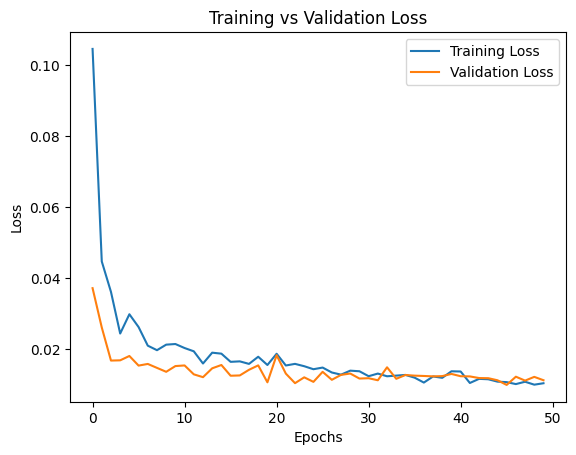

In [3]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Evaluate the model
loss, mse = nn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test MSE: {mse:.4f}")

# Calculate R² Score
y_pred = nn_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [5]:
import pickle

# Bundle the model and preprocessor
model_preprocessor_bundle = {
    'model': nn_model,
    'preprocessor': preprocessor
}

# Save to a pickle file
file_path = '../data/model/nn_model_and_preprocessor.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model_preprocessor_bundle, file)

print(f"Model and preprocessor saved to {file_path}")


Model and preprocessor saved to ../data/model/nn_model_and_preprocessor.pkl


In [6]:
example_xg = predict_xg(0.95, 0.500, 'LeftFoot', 'HeadPass', 'FromCorner')
print(f"Predicted xG: {example_xg:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted xG: 0.5370
